---
title: "Lab 6 - Variable Selection and Regularization"
author: "Tyler Allen"
date: "2024-11-11"
format:
  html:
    cold-fold: true
    embed-resources: true
theme: "lux"
---

Dataset: Baseball Players
In this lab, we will use predictive modeling to design a model that predicts a baseball player’s salary in a given year.

This dataset was originally taken from the StatLib library which is maintained at Carnegie Mellon University. This is part of the data that was used in the 1988 ASA Graphics Section Poster Session. The salary data were originally from Sports Illustrated, April 20, 1987. The 1986 and career statistics were obtained from The 1987 Baseball Encyclopedia Update published by Collier Books, Macmillan Publishing Company, New York.

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Hitters.csv to Hitters.csv


In [3]:
import pandas as pd
df = pd.read_csv('Hitters.csv')
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [7]:
#removing rows where Salary has NaN values
df_cleaned = df.dropna(subset=['Salary'])

#confirm that missing values are removed
df_cleaned.isnull().sum()

,0
AtBat,0
Hits,0
HmRun,0
Runs,0
RBI,0
Walks,0
Years,0
CAtBat,0
CHits,0
CHmRun,0


In [8]:
from sklearn.preprocessing import OneHotEncoder

#OneHotEncoder for the categorical columns
df_encoded = pd.get_dummies(df_cleaned, columns=['League', 'Division', 'NewLeague'])

#check
df_encoded.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,PutOuts,Assists,Errors,Salary,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,...,632,43,10,475.0,False,True,False,True,False,True
2,479,130,18,66,72,76,3,1624,457,63,...,880,82,14,480.0,True,False,False,True,True,False
3,496,141,20,65,78,37,11,5628,1575,225,...,200,11,3,500.0,False,True,True,False,False,True
4,321,87,10,39,42,30,2,396,101,12,...,805,40,4,91.5,False,True,True,False,False,True
5,594,169,4,74,51,35,11,4408,1133,19,...,282,421,25,750.0,True,False,False,True,True,False


**Part 1: Different Model Specs**

*A. Regression without regularization*

Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary linear regression


In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

#identifying the numeric columns and one-hot encoded categorical columns in the data
numeric_features = df_encoded.drop(columns=['Salary']).select_dtypes(include=['int64', 'float64']).columns.tolist()

#ColumnTransformer with remainder="passthrough" to handle all columns without specifying each one individually
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features)  #standardize numeric features
    ],
    remainder="passthrough",
    force_int_remainder_cols=False  #suppress the future warning
)

#pipeline with preprocessor and linear regression
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['AtBat', 'Hits', 'HmRun',
                                                   'Runs', 'RBI', 'Walks',
                                                   'Years', 'CAtBat', 'CHits',
                                                   'CHmRun', 'CRuns', 'CRBI',
                                                   'CWalks', 'PutOuts',
                                                   'Assists', 'Errors'])])),
                ('regressor', LinearRegression())])

Fit this pipeline to the full dataset, and interpret a few of the most important coefficients.

In [14]:
X = df_encoded.drop(columns=['Salary'])
y = df_encoded['Salary']

#fit the pipeline
pipeline.fit(X, y)

#retrieving the coefficients from the fitted linear regression model
coefficients = pipeline.named_steps['regressor'].coef_
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

#df to help display the coefficients for interpretation
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coefficients_df = coefficients_df.sort_values(by='Coefficient', key=abs, ascending=False).head(10)

coefficients_df

,Feature,Coefficient
10,num__CRuns,480.747135
7,num__CAtBat,-391.038655
1,num__Hits,337.830479
0,num__AtBat,-291.094556
11,num__CRBI,260.689886
12,num__CWalks,-213.892259
5,num__Walks,135.073897
8,num__CHits,86.687617
13,num__PutOuts,78.761296
3,num__Runs,-60.572479


The variable num_CRuns has a very large positive coefficient, meaning that higher number of career runs are associated with a higher salary. In other words, players who have scored more runs in their career as usually more valuable than people who have scored less, which usually results in a higher salary.

The variable num_CAtBat has a large and negative coefficient, meaning that a high number of career at-bats is associated with a lower salary. This could be due to the fact that older players with more at-bats are not as good anymore so they don't get as big of a salary.

Other variables such as num_Hits, num_CRBI, num_Walks, and num_CHits all have positive coefficients, which makes sense because players who get more hits, RBIs, walks and career hits should get paid more.


Use cross-validation to estimate the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np

#using cross_val_score to estimate the MSE
mse_scores = cross_val_score(pipeline, X, y, scoring='neg_mean_squared_error', cv=5)

#convert negative MSE scores to positive and calculate the average MSE
mean_mse = -np.mean(mse_scores)
mean_mse

121136.31031816888

*B. Ridge regression*

Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression


In [21]:
from sklearn.linear_model import Ridge

#pipeline with preprocessor and ridge regression
ridge_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", Ridge())
])

ridge_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['AtBat', 'Hits', 'HmRun',
                                                   'Runs', 'RBI', 'Walks',
                                                   'Years', 'CAtBat', 'CHits',
                                                   'CHmRun', 'CRuns', 'CRBI',
                                                   'CWalks', 'PutOuts',
                                                   'Assists', 'Errors'])])),
                ('regressor', Ridge())])

Use cross-validation to tune the lambda hyperparameter.



In [26]:
from sklearn.model_selection import GridSearchCV

#range of lambda (alpha) values to test
alpha_range = [0.001, 0.01, 0.1, 1, 10]

#update the pipeline
ridge_pipeline = Pipeline(steps=[
    ("preprocessor", ColumnTransformer(
        transformers=[("num", StandardScaler(), numeric_features)], #standardizing numeric values
        remainder="passthrough",
        force_int_remainder_cols=False
    )),
    ("regressor", Ridge())
])

#setting up GridSearchCV to tune the lambda (alpha) parameter
param_grid = {'regressor__alpha': alpha_range}
grid_search = GridSearchCV(ridge_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

#GridSearchCV to find the best lambda (alpha)
grid_search.fit(X, y)

#find best alpha value and corresponding MSE
best_alpha = grid_search.best_params_['regressor__alpha']
best_mse = -grid_search.best_score_

best_alpha, best_mse

(1, 119144.43267691587)

Fit the pipeline with your chosen lambda to the full dataset, and interpret a few of the most important coefficients.

In [28]:
#updating the Ridge model in the pipeline with the best alpha value and fit to the full dataset
ridge_pipeline.set_params(regressor__alpha=best_alpha)
ridge_pipeline.fit(X, y)

#getting the coefficients from the fitted ridge regression model
ridge_coefficients = ridge_pipeline.named_steps['regressor'].coef_

#df to display the coefficients for interpretation
ridge_coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': ridge_coefficients})
ridge_coefficients_df = ridge_coefficients_df.sort_values(by='Coefficient', key=abs, ascending=False).head(10)
ridge_coefficients_df

,Feature,Coefficient
10,num__CRuns,320.412169
1,num__Hits,296.645050
0,num__AtBat,-270.686441
7,num__CAtBat,-225.406548
12,num__CWalks,-184.423611
11,num__CRBI,160.386784
8,num__CHits,126.659607
5,num__Walks,124.407173
13,num__PutOuts,78.623656
19,remainder__Division_W,-60.015595


The variable num_CRuns has the largest (positive) coefficient, indicating that a higher amount of career runs is strongly associated with a higher salary.

The variables num__CAtBat and num__AtBat both have large negative coefficients, showing that a higher number of at-bats within a season is associated with a lower salary. This could be for many reasons, firstly being that pitchers make a lot of money and do not bat very much. The second being that the majority of players who have a lot of at bats don't produce as much, it is only a certain percentage of top players who produce well with many at bats.

This model has slightly lower coefficients than the ordinary linear regression model due to regularization, which has helped reduce the impact of less significant variables.

Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [29]:
#cross-validation on the ridge pipeline
ridge_mse_scores = cross_val_score(ridge_pipeline, X, y, scoring='neg_mean_squared_error', cv=5)

#convert negative MSE scores to positive and calculate the average MSE
expected_mse = -np.mean(ridge_mse_scores)
expected_mse

119144.43267691587

*C. Lasso Regression*

Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary lasso regression


In [30]:
from sklearn.linear_model import Lasso

#pipeline with preprocessor and lasso regression
lasso_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", Lasso())
])

lasso_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['AtBat', 'Hits', 'HmRun',
                                                   'Runs', 'RBI', 'Walks',
                                                   'Years', 'CAtBat', 'CHits',
                                                   'CHmRun', 'CRuns', 'CRBI',
                                                   'CWalks', 'PutOuts',
                                                   'Assists', 'Errors'])])),
                ('regressor', Lasso())])


Use cross-validation to tune the lambda
 hyperparameter.


In [32]:
#suppress specific convergence warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.linear_model")

alpha_range = [0.001, 0.01, 0.1, 1, 10]

#GridSearchCV to tune the lambda (alpha) parameter for Lasso regression
param_grid = {'regressor__alpha': alpha_range}
grid_search_lasso = GridSearchCV(lasso_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

#fit GridSearchCV
grid_search_lasso.fit(X, y)

best_alpha_lasso = grid_search_lasso.best_params_['regressor__alpha']
best_mse_lasso = -grid_search_lasso.best_score_

best_alpha_lasso, best_mse_lasso

(1, 119761.6283132603)

Fit the pipeline with your chosen lambda
 to the full dataset, and interpret a few of the most important coefficients.


In [33]:
#update the Lasso model in the pipeline
lasso_pipeline.set_params(regressor__alpha=best_alpha_lasso)
lasso_pipeline.fit(X, y)

#getting the coefficients from the fitted lasso regression model
lasso_coefficients = lasso_pipeline.named_steps['regressor'].coef_

#df to display the coefficients for interpretation
lasso_coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': lasso_coefficients})
lasso_coefficients_df = lasso_coefficients_df[lasso_coefficients_df['Coefficient'] != 0]  #keep only non-zero coefficients
lasso_coefficients_df = lasso_coefficients_df.sort_values(by='Coefficient', key=abs, ascending=False).head(10)
lasso_coefficients_df

,Feature,Coefficient
10,num__CRuns,375.565034
1,num__Hits,304.358267
0,num__AtBat,-282.369623
11,num__CRBI,192.616442
12,num__CWalks,-189.643123
7,num__CAtBat,-162.644108
5,num__Walks,120.694778
18,remainder__Division_E,114.412953
13,num__PutOuts,78.760260
14,num__Assists,41.996661


Many of the coefficients here are very similar. A new interesting one is the variable remainder__Division_E which has a coefficient of 114.41. This indicates that players who play in the Eastern Division tend to have higher salaries than those in Western Division. There are many reasons as to why this could be case (market, competition, budgets) but we don't have enough information to speculate on that.

Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [34]:
#cross-validation on the lasso pipeline
lasso_mse_scores = cross_val_score(lasso_pipeline, X, y, scoring='neg_mean_squared_error', cv=5)
expected_mse_lasso = -np.mean(lasso_mse_scores)
expected_mse_lasso

119761.6283132603

*D. Elastic Net*

Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression



In [36]:
# Suppress the specific FutureWarning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.compose._column_transformer")

from sklearn.linear_model import ElasticNet

#pipeline with preprocessor and elastic net regression
elastic_net_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", ElasticNet())
])

elastic_net_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['AtBat', 'Hits', 'HmRun',
                                                   'Runs', 'RBI', 'Walks',
                                                   'Years', 'CAtBat', 'CHits',
                                                   'CHmRun', 'CRuns', 'CRBI',
                                                   'CWalks', 'PutOuts',
                                                   'Assists', 'Errors'])])),
                ('regressor', ElasticNet())])

Use cross-validation to tune the lambda
 and alpha
 hyperparameters.



In [37]:
#range of alpha (regularization strength) and l1_ratio (lasso-ridge mix) values to test
alpha_range = [0.001, 0.01, 0.1, 1, 10]
l1_ratio_range = [0.1, 0.5, 0.9]  #values from mostly ridge (0) to mostly lasso (1)

#GridSearchCV to tune the alpha and l1_ratio parameters for ElasticNet
param_grid = {
    'regressor__alpha': alpha_range,
    'regressor__l1_ratio': l1_ratio_range
}
grid_search_elastic_net = GridSearchCV(elastic_net_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

#fit GridSearchCV to find the best combo of alpha and l1_ratio
grid_search_elastic_net.fit(X, y)

#getting the best parameters and corresponding MSE
best_alpha_elastic_net = grid_search_elastic_net.best_params_['regressor__alpha']
best_l1_ratio_elastic_net = grid_search_elastic_net.best_params_['regressor__l1_ratio']
best_mse_elastic_net = -grid_search_elastic_net.best_score_

best_alpha_elastic_net, best_l1_ratio_elastic_net, best_mse_elastic_net

(0.1, 0.9, 118969.4914559725)

Fit the pipeline with your chosen hyperparameters to the full dataset, and interpret a few of the most important coefficients.



In [39]:
#update the ElasticNet model in the pipeline with the best alpha and l1_ratio values and fit to the full dataset
elastic_net_pipeline.set_params(regressor__alpha=best_alpha_elastic_net, regressor__l1_ratio=best_l1_ratio_elastic_net)
elastic_net_pipeline.fit(X, y)

#get the coefficients from the fitted elastic net regression model
elastic_net_coefficients = elastic_net_pipeline.named_steps['regressor'].coef_

#df to display the coefficients for interpretation
elastic_net_coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': elastic_net_coefficients})
elastic_net_coefficients_df = elastic_net_coefficients_df[elastic_net_coefficients_df['Coefficient'] != 0]
elastic_net_coefficients_df = elastic_net_coefficients_df.sort_values(by='Coefficient', key=abs, ascending=False).head(10)
elastic_net_coefficients_df

,Feature,Coefficient
1,num__Hits,247.556168
0,num__AtBat,-231.507759
10,num__CRuns,223.037799
12,num__CWalks,-154.668795
11,num__CRBI,121.693876
8,num__CHits,120.015087
7,num__CAtBat,-115.294004
5,num__Walks,110.808219
13,num__PutOuts,77.918536
19,remainder__Division_W,-60.671699


The variable num__Hits has the largest [positive] coefficient, which makes sense because a player with more hits should have a higher salary than one with less hits. The variables num__CRuns, num__CRBI, num__CHits are still positively large, while the variables num__AtBat, num__CWalks, and num__CAtBat remain negatively large, similar to the rest of the models.

Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [40]:
#cross-validation on the elastic net pipeline
elastic_net_mse_scores = cross_val_score(elastic_net_pipeline, X, y, scoring='neg_mean_squared_error', cv=5)
expected_mse_elastic_net = -np.mean(elastic_net_mse_scores)
expected_mse_elastic_net

118969.4914559725

**Part 2: Variable Selection**

Based on the above results, decide on:

Which numeric variable is most important.

Which five numeric variables are most important

Which categorical variable is most important



Across the 4 models, the variable Career Runs had a consistent large positive coefficient, which is why I believe that is the numeric variable that is most important.

The five numerical variables that are most important are hits, career runs, at bats, career RBI, and career walks (in no order).

The categorical variable that is most important is the Eastern Division (Division_E) variable.

For each of the four model specifications, compare the following possible feature sets:

Using only the one best numeric variable.

Using only the five best variables.

Using the five best numeric variables and their interactions with the one best categorical variable.

Report which combination of features and model performed best, based on the validation metric of MSE.

(Note: lambda and alpha must be re-tuned for each feature set.)

In [49]:
#defining the best numeric and categorical features based on previous analysis
best_numeric_variable = ['Hits']
top_five_numeric_variables = ['Hits', 'CRuns', 'AtBat', 'CRBI', 'CWalks']
categorical_variable = 'Division'

# Initialize an empty dictionary to store results
results = {}
#redefining function to help with modeling (used ChatGPT for help with these functions)
def evaluate_model(model, feature_set, feature_name):
    #selecting the relevant features for the current feature set
    X_subset = X[feature_set] if isinstance(feature_set, list) else feature_set  #handle arrays

    pipeline = Pipeline(steps=[
        ("preprocessor", StandardScaler()),
        ("regressor", model)  #use specified model
    ])

    #define parameter grid for models that require tuning
    if isinstance(model, Ridge) or isinstance(model, Lasso):
        param_grid = {
            'regressor__alpha': [0.001, 0.01, 0.1, 1, 10]
        }
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_subset, y)

        #get best MSE and parameters
        best_mse = -grid_search.best_score_
        best_params = grid_search.best_params_

    elif isinstance(model, ElasticNet):
        param_grid = {
            'regressor__alpha': [0.001, 0.01, 0.1, 1, 10],
            'regressor__l1_ratio': [0.1, 0.5, 0.9]
        }
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_subset, y)

        #get best MSE and parameters
        best_mse = -grid_search.best_score_
        best_params = grid_search.best_params_

    else:
        #ordinary linear regression doesn't need tuning
        best_params = None
        scores = cross_val_score(pipeline, X_subset, y, scoring='neg_mean_squared_error', cv=5)
        best_mse = -scores.mean()

    #store results
    results[(model.__class__.__name__, feature_name)] = (best_mse, best_params)

In [50]:
#redefine the interaction terms
from sklearn.preprocessing import PolynomialFeatures

X_interaction = X[top_five_numeric_variables + ['Division_W']]
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interaction = poly.fit_transform(X_interaction)

#re-run the evaluations with the corrected interaction terms
results = {}

#only the one best numeric variable
evaluate_model(LinearRegression(), best_numeric_variable, "One Best Numeric Variable")
evaluate_model(Ridge(), best_numeric_variable, "One Best Numeric Variable")
evaluate_model(Lasso(), best_numeric_variable, "One Best Numeric Variable")
evaluate_model(ElasticNet(), best_numeric_variable, "One Best Numeric Variable")

#five best numeric variables
evaluate_model(LinearRegression(), top_five_numeric_variables, "Five Best Numeric Variables")
evaluate_model(Ridge(), top_five_numeric_variables, "Five Best Numeric Variables")
evaluate_model(Lasso(), top_five_numeric_variables, "Five Best Numeric Variables")
evaluate_model(ElasticNet(), top_five_numeric_variables, "Five Best Numeric Variables")

#five best numeric variables and their interactions with Division
evaluate_model(LinearRegression(), X_interaction, "Five Best Numeric + Interaction with Categorical")
evaluate_model(Ridge(), X_interaction, "Five Best Numeric + Interaction with Categorical")
evaluate_model(Lasso(), X_interaction, "Five Best Numeric + Interaction with Categorical")
evaluate_model(ElasticNet(), X_interaction, "Five Best Numeric + Interaction with Categorical")

#display the results in an easy to read way
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['MSE', 'Best Parameters'])
results_df

,MSE,Best Parameters
"(LinearRegression, One Best Numeric Variable)",173088.972864,None
"(Ridge, One Best Numeric Variable)",172755.975523,{'regressor__alpha': 10}
"(Lasso, One Best Numeric Variable)",173061.634500,{'regressor__alpha': 10}
"(ElasticNet, One Best Numeric Variable)",172603.554302,"{'regressor__alpha': 0.1, 'regressor__l1_ratio..."
"(LinearRegression, Five Best Numeric Variables)",125502.852876,None
"(Ridge, Five Best Numeric Variables)",125142.787641,{'regressor__alpha': 1}
"(Lasso, Five Best Numeric Variables)",125290.065453,{'regressor__alpha': 1}
"(ElasticNet, Five Best Numeric Variables)",124989.657908,"{'regressor__alpha': 0.1, 'regressor__l1_ratio..."
"(LinearRegression, Five Best Numeric + Interaction with Categorical)",186568.645947,None
"(Ridge, Five Best Numeric + Interaction with Categorical)",117573.967944,{'regressor__alpha': 10}


Based on the validation metric of MSE, the model that performed the best was the one that used elastic net regression with the five best numerical variables and their interaction with the chosen categorical variable.

**Part 3: Discussion**

A. Ridge

Compare your Ridge models with your ordinary regression models. How did your coefficients compare? Why does this make sense?

The coefficients in the Ridge models were slightly lower. This makes sense because the Ridge models used regularization, which creates a shrinking effect so that a model which has variables that are correlated has lower potential to overfit.

B. LASSO

Compare your LASSO model in I with your three LASSO models in II. Did you get the same lambda results? Why does this make sense? Did you get the same MSEs? Why does this make sense?

My Lasso model in 1 had an optimal lambda of 1, whereas the three Lasso models had an optimal lamba of 1 for the model using just the five best numerical variables and an optimal lambda of 10 for the model using just one best numerical variable and the model using the five best numerical variables plus the interaction with the categorical variable. This partially makes sense because models with multiple predictors will usually have a higher lambda to deal with additional noise or multicollinearity, versus models with maybe only one predictor where a lower lambda value would work better.

The MSE for the Lasso model in 1 (119761) was higher than the Lasso model using the five best numerical variables plus the interaction with the categorical variable (115717), but was lower than the Lasso model only using the one best numerical variable (173061) and the Lasso model using the the five best numerical variables (125290). This makes sense because more features in a model ususally improve the model's accuracy, which is why the model with the most features has the lowest MSE.  

C. Elastic Net

Compare your MSEs for the Elastic Net models with those for the Ridge and LASSO models. Why does it make sense that Elastic Net always “wins”?

The Elastic Net models had a lower MSE than the Ridge and Lasso models every time. It makes sense that Elastic Net always "wins" because it has the ability to use both regularization techniques which in turns gives a model that is able to balance feature selection with coefficient stabilization in order to receieve lower MSEs.

**Part 4: Final Model**

Fit your final best pipeline on the full dataset, and summarize your results in a few short sentences and a plot.

In [52]:
#used ChatGPT to help me pull the model and feature set with the lowest MSE in the results
best_model_entry = min(results, key=lambda x: results[x][0])
best_model_name, best_feature_set = best_model_entry
best_model_mse = results[best_model_entry][0]
best_params = results[best_model_entry][1]

#showing the best model, feature set, MSE, and parameters to confirm that I'm using the best model
best_model_info = {
    "Best Model": best_model_name,
    "Feature Set": best_feature_set,
    "MSE": best_model_mse,
    "Parameters": best_params
}
best_model_info

{'Best Model': 'ElasticNet',
 'Feature Set': 'Five Best Numeric + Interaction with Categorical',
 'MSE': 105485.8292176768,
 'Parameters': {'regressor__alpha': 1, 'regressor__l1_ratio': 0.5}}

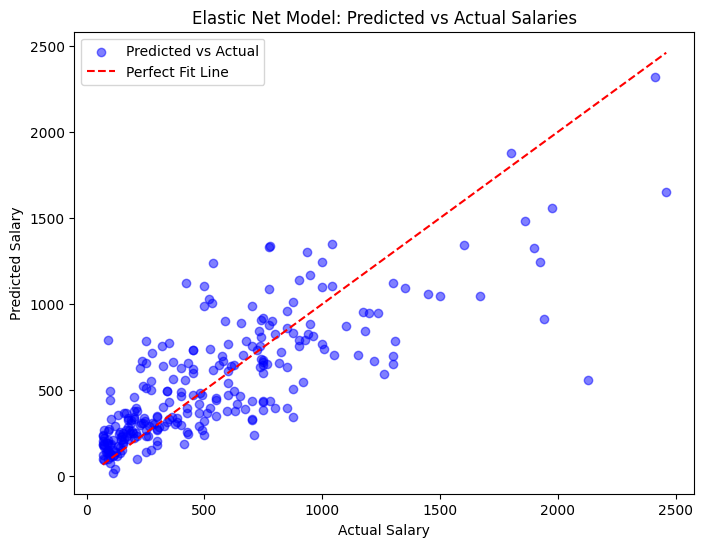

In [53]:
#extracting the optimal alpha and l1_ratio from the best Elastic Net model parameters
alpha_optimal = best_params['regressor__alpha']
l1_ratio_optimal = best_params['regressor__l1_ratio']

#fit the Elastic Net model on the full dataset using the optimal parameters
final_model = ElasticNet(alpha=alpha_optimal, l1_ratio=l1_ratio_optimal)

#fit the model on the best feature set (five best numeric variables with interaction terms)
final_model.fit(X_interaction, y)

#get predictions and calculate MSE for plot
y_pred = final_model.predict(X_interaction)

#plot comparing actual vs. predicted values
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, alpha=0.5, label='Predicted vs Actual', color='blue')
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--', label='Perfect Fit Line')
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Elastic Net Model: Predicted vs Actual Salaries')
plt.legend()
plt.show()

Here is a scatterplot showing a line which represents perfect predictions and dots that represent actual versus predicted salary values. Points that are close to the line indicate strong model performance. As you can see above, the model does a good job because many of the points lie close to the red line. As the salary increases, the points get further away, indicating that the model is more effective for predicting lower to mid-range salaries than it is for high salaries. It is worth pointing out that the model underpredicts higher salaries, which is likely due to the lesser amount of higher salaries that are included in the model.